In [ ]:
#Modelo de Clasificación para Trading Algorítmico
#Pipeline completo de Machine Learning para predecir movimientos de precios.

In [ ]:
## 1. Instalación de librerías

In [2]:
# Instalar librerías necesarias
!pip install scikit-learn==1.3.0 xgboost lightgbm catboost imbalanced-learn numpy==1.24.3 -q

In [3]:
# Verificar imports
try:
    import sklearn
    import xgboost
    import lightgbm
    import catboost
    print(" Todas las librerías instaladas correctamente")
    print(f"   scikit-learn: {sklearn.__version__}")
    print(f"   xgboost: {xgboost.__version__}")
    print(f"   lightgbm: {lightgbm.__version__}")
    print(f"   catboost: {catboost.__version__}")
except ImportError as e:
    print(f" Error: {e}")

 Todas las librerías instaladas correctamente
   scikit-learn: 1.3.0
   xgboost: 3.1.2
   lightgbm: 4.6.0
   catboost: 1.2.8


In [ ]:
## 2. Imports y configuración

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# SQL
from sqlalchemy import create_engine, text

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)

# Serialización
import joblib

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(" Librerías importadas correctamente")

 Librerías importadas correctamente


In [ ]:
## 3. Conexión a PostgreSQL

In [5]:
# Configuración
PG_HOST = os.getenv('PG_HOST', 'postgres')
PG_PORT = os.getenv('PG_PORT', '5432')
PG_DB = os.getenv('PG_DB', 'trading_db')
PG_USER = os.getenv('PG_USER', 'trading_user')
PG_PASSWORD = os.getenv('PG_PASSWORD', 'TradingPass2024!')

# Conexión
connection_string = f"postgresql://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB}"
engine = create_engine(connection_string)

# Verificar conexión
with engine.connect() as conn:
    result = conn.execute(text("SELECT COUNT(*) FROM analytics.daily_features"))
    count = result.fetchone()[0]
    print(f" Conectado - {count:,} registros en analytics.daily_features")

 Conectado - 1,232 registros en analytics.daily_features


In [ ]:
## 4. Definición del problema
#Objetivo: Predecir si AAPL cerrará ARRIBA o ABAJO respecto a su apertura.


In [ ]:
## 5. Carga de datos

In [6]:
# Cargar datos
query = """
SELECT 
    date, ticker, year, month, day_of_week,
    open, close, high, low, volume,
    return_close_open, return_prev_close,
    volatility_5_days, volatility_10_days, volatility_20_days,
    close_lag1, close_lag2, close_lag3, volume_lag1,
    is_monday, is_friday
FROM analytics.daily_features
WHERE ticker = 'AAPL'
ORDER BY date;
"""

df = pd.read_sql(query, engine)

print(f" Datos cargados: {len(df):,} registros")
print(f"   Ticker: {df['ticker'].unique()[0]}")
print(f"   Rango: {df['date'].min()} a {df['date'].max()}")

# Mostrar primeras filas
display(df.head())

 Datos cargados: 1,232 registros
   Ticker: AAPL
   Rango: 2021-01-04 a 2025-11-26


,date,ticker,year,month,day_of_week,open,close,high,low,volume,...,return_prev_close,volatility_5_days,volatility_10_days,volatility_20_days,close_lag1,close_lag2,close_lag3,volume_lag1,is_monday,is_friday
0,2021-01-04,AAPL,2021,1,0,129.9753,125.9744,130.0629,123.3948,143301900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
1,2021-01-05,AAPL,2021,1,1,125.4683,127.5320,128.2426,125.0205,97664900,...,0.012364,NaN,NaN,NaN,125.9744,NaN,NaN,143301900.0,False,False
2,2021-01-06,AAPL,2021,1,2,124.3293,123.2391,127.5709,123.0249,155088000,...,-0.033661,0.032545,NaN,NaN,127.5320,125.9744,NaN,97664900.0,False,False
3,2021-01-07,AAPL,2021,1,3,124.9523,127.4444,128.1355,124.4656,109578200,...,0.034123,0.034609,NaN,NaN,123.2391,127.5320,125.9744,155088000.0,False,False
4,2021-01-08,AAPL,2021,1,4,128.9143,128.5444,129.1090,126.7727,105158200,...,0.008631,0.028342,NaN,NaN,127.4444,123.2391,127.5320,109578200.0,False,True


In [ ]:
## 6. Crear variable TARGET

In [7]:
# Crear target
df['target_up'] = (df['close'] > df['open']).astype(int)

# Estadísticas
print(" Distribución del TARGET:\n")
print(df['target_up'].value_counts())
print(f"\n% Días UP (1): {df['target_up'].mean()*100:.2f}%")
print(f"% Días DOWN (0): {(1-df['target_up'].mean())*100:.2f}%")

# Balance de clases
balance = abs(df['target_up'].mean() - 0.5)
if balance < 0.1:
    print("\n Clases están balanceadas")
else:
    print(f"\n  Clases ligeramente desbalanceadas (diferencia: {balance*100:.1f}%)")

 Distribución del TARGET:

target_up
1    658
0    574
Name: count, dtype: int64

% Días UP (1): 53.41%
% Días DOWN (0): 46.59%

 Clases están balanceadas


In [ ]:
## 7. Análisis Exploratorio (EDA)

In [8]:
# Información del dataset
print(" Información del dataset:\n")
print(df.info())

print("\n Estadísticas descriptivas:")
display(df.describe())

# Verificar nulos
print("\n Valores nulos:")
nulls = df.isnull().sum()
if nulls.sum() > 0:
    display(nulls[nulls > 0])
else:
    print(" No hay valores nulos")

 Información del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1232 non-null   object 
 1   ticker              1232 non-null   object 
 2   year                1232 non-null   int64  
 3   month               1232 non-null   int64  
 4   day_of_week         1232 non-null   int64  
 5   open                1232 non-null   float64
 6   close               1232 non-null   float64
 7   high                1232 non-null   float64
 8   low                 1232 non-null   float64
 9   volume              1232 non-null   int64  
 10  return_close_open   1232 non-null   float64
 11  return_prev_close   1231 non-null   float64
 12  volatility_5_days   1230 non-null   float64
 13  volatility_10_days  1227 non-null   float64
 14  volatility_20_days  1222 non-null   float64
 15  close_lag1          1231 non

,year,month,day_of_week,open,close,high,low,volume,return_close_open,return_prev_close,volatility_5_days,volatility_10_days,volatility_20_days,close_lag1,close_lag2,close_lag3,volume_lag1,target_up
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1.232000e+03,1232.000000,1231.000000,1230.000000,1227.000000,1222.000000,1231.000000,1230.000000,1229.000000,1.231000e+03,1232.000000
mean,2022.960227,6.453734,2.026786,177.547047,177.732701,179.496446,175.792094,7.035210e+07,0.001114,0.000797,0.015275,0.016021,0.016483,177.651614,177.570868,177.490844,7.038209e+07,0.534091
std,1.401244,3.381433,1.398071,38.119243,38.190202,38.422704,37.895790,2.979249e+07,0.014885,0.017686,0.009129,0.007819,0.006756,38.099479,38.009456,37.921130,2.978598e+07,0.499039
min,2021.000000,1.000000,0.000000,116.043200,113.440200,117.378800,113.293900,2.323470e+07,-0.076487,-0.092456,0.000909,0.003657,0.005960,113.440200,113.440200,113.440200,2.323470e+07,0.000000
25%,2022.000000,4.000000,1.000000,145.734150,145.935275,147.280775,144.417375,4.878315e+07,-0.006425,-0.008023,0.009285,0.010974,0.012167,145.926450,145.917625,145.908800,4.880845e+07,0.000000
50%,2023.000000,6.000000,2.000000,170.989400,171.309350,172.353550,169.395900,6.380945e+07,0.000817,0.001140,0.013250,0.014544,0.015300,171.292700,171.285150,171.277600,6.381490e+07,1.000000
75%,2024.000000,9.000000,3.000000,207.539675,207.939075,210.790925,205.499025,8.492275e+07,0.009265,0.010045,0.019184,0.019232,0.019242,207.759050,207.659825,207.659600,8.492310e+07,1.000000
max,2025.000000,12.000000,4.000000,276.960000,277.550000,280.380000,276.630000,3.186799e+08,0.156441,0.153288,0.099051,0.070883,0.051535,276.970000,275.920000,275.250000,3.186799e+08,1.000000



 Valores nulos:


return_prev_close      1
volatility_5_days      2
volatility_10_days     5
volatility_20_days    10
close_lag1             1
close_lag2             2
close_lag3             3
volume_lag1            1
dtype: int64

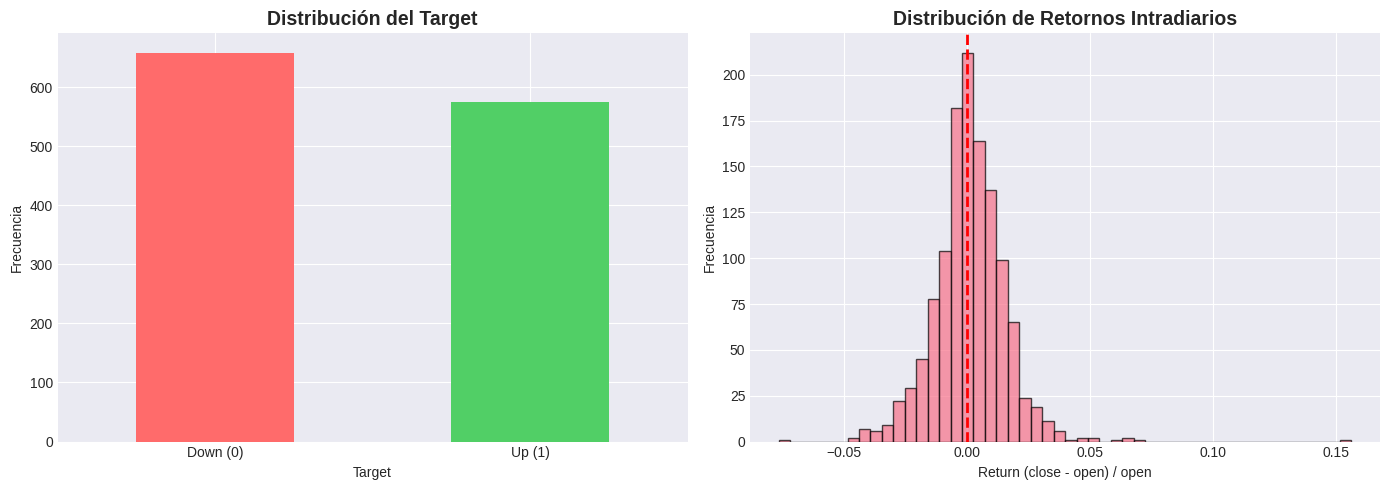

In [9]:
# Visualización: Distribución del target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Balance de clases
df['target_up'].value_counts().plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#51cf66'])
axes[0].set_title('Distribución del Target', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xticklabels(['Down (0)', 'Up (1)'], rotation=0)

# Retornos intradiarios
axes[1].hist(df['return_close_open'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Retornos Intradiarios', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Return (close - open) / open')
axes[1].set_ylabel('Frecuencia')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

In [ ]:
## 8. Correlaciones entre features y target

 Correlaciones con TARGET:

target_up             1.000000
return_prev_close     0.584745
month                 0.046428
volatility_20_days   -0.021502
day_of_week          -0.025179
volatility_5_days    -0.029449
volatility_10_days   -0.041797
Name: target_up, dtype: float64


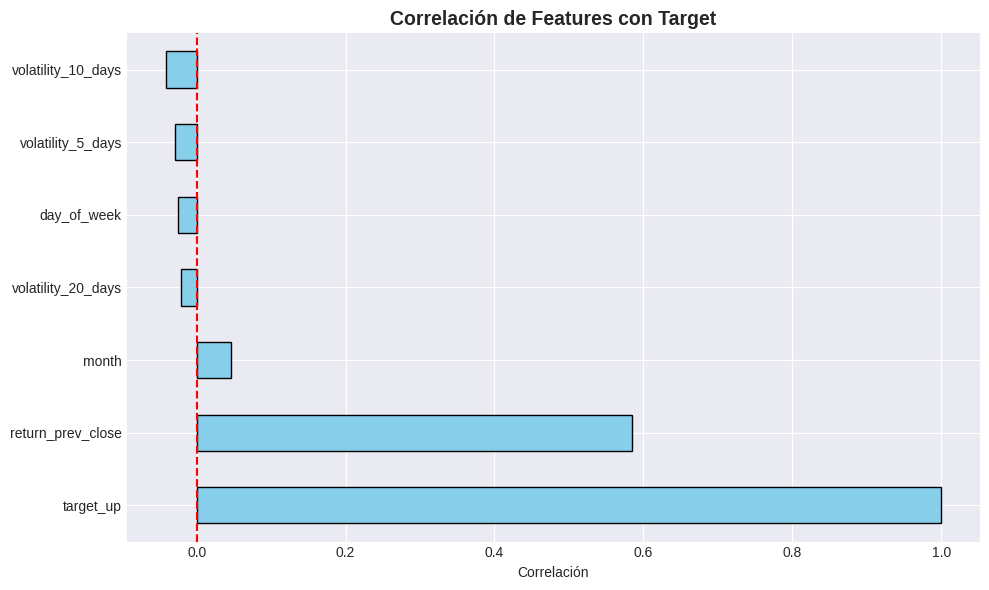


 Nota: Correlaciones bajas son normales en problemas de trading


In [10]:
# Seleccionar features numéricas
numeric_cols = [
    'return_prev_close', 'volatility_5_days', 'volatility_10_days', 
    'volatility_20_days', 'volume', 'day_of_week', 'month'
]

# Calcular correlaciones con el target
correlations = df[numeric_cols + ['target_up']].corr()['target_up'].sort_values(ascending=False)

print(" Correlaciones con TARGET:\n")
print(correlations[:-1])  # Excluir la correlación consigo mismo

# Visualización
plt.figure(figsize=(10, 6))
correlations[:-1].plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Correlación de Features con Target', fontsize=14, fontweight='bold')
plt.xlabel('Correlación')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

print("\n Nota: Correlaciones bajas son normales en problemas de trading")

In [ ]:
## 9. Selección y preparación de features: Se seleccionaran features relevantes, 
#Eliminar filas con nulos en features críticas,Preparar X (features) e y (target)


In [11]:
# Features a usar (SIN close, high, low del mismo día para evitar leakage)
feature_columns = [
    # Lags de precios (información del pasado)
    'close_lag1', 'close_lag2', 'close_lag3',
    
    # Retornos pasados
    'return_prev_close',
    
    # Volatilidad
    'volatility_5_days', 'volatility_10_days', 'volatility_20_days',
    
    # Volumen
    'volume_lag1',
    
    # Features temporales
    'day_of_week', 'month',
    
    # Flags
    'is_monday', 'is_friday'
]

print(f" Features seleccionadas: {len(feature_columns)}")
print("\n", feature_columns)

# Verificar que todas existen
missing = [col for col in feature_columns if col not in df.columns]
if missing:
    print(f"\n  Columnas faltantes: {missing}")
else:
    print("\n Todas las features están disponibles")

 Features seleccionadas: 12

 ['close_lag1', 'close_lag2', 'close_lag3', 'return_prev_close', 'volatility_5_days', 'volatility_10_days', 'volatility_20_days', 'volume_lag1', 'day_of_week', 'month', 'is_monday', 'is_friday']

 Todas las features están disponibles


In [12]:
# Crear dataset de ML
df_ml = df[['date', 'ticker'] + feature_columns + ['target_up']].copy()

print(f" Dataset ML inicial: {len(df_ml):,} registros")

# Eliminar filas con nulos en features críticas
df_ml = df_ml.dropna(subset=feature_columns)

print(f" Después de eliminar nulos: {len(df_ml):,} registros")
print(f"   Registros eliminados: {len(df) - len(df_ml)}")

# Mostrar primeras filas
display(df_ml.head())

 Dataset ML inicial: 1,232 registros
 Después de eliminar nulos: 1,222 registros
   Registros eliminados: 10


,date,ticker,close_lag1,close_lag2,close_lag3,return_prev_close,volatility_5_days,volatility_10_days,volatility_20_days,volume_lag1,day_of_week,month,is_monday,is_friday,target_up
10,2021-01-19,AAPL,123.7647,125.4877,127.4152,0.005427,0.013203,0.020458,0.020458,111598500.0,1,1,False,False,1
11,2021-01-20,AAPL,124.4364,123.7647,125.4877,0.032856,0.020360,0.022837,0.021934,90757300.0,2,1,False,False,1
12,2021-01-21,AAPL,128.5249,124.4364,123.7647,0.036658,0.024726,0.021777,0.023178,104319500.0,3,1,False,False,1
13,2021-01-22,AAPL,133.2364,128.5249,124.4364,0.016074,0.020646,0.020055,0.022406,120150900.0,4,1,False,True,1
14,2021-01-25,AAPL,135.3780,133.2364,128.5249,0.027684,0.012842,0.021181,0.022308,114459400.0,0,1,True,False,0


In [ ]:
## 10. Split temporal (Train / Validation / Test)

##**Importante**: NO usar split aleatorio, sino temporal:
## **Train**: 2021-01-04 a 2023-12-31 (~3 años)
## **Validation**: 2024-01-01 a 2024-12-31 (~1 año)
## **Test**: 2025-01-01 a 2025-11-26 (~11 meses) → Para simulación

In [14]:
# Convertir columna date a datetime si no lo es
df_ml['date'] = pd.to_datetime(df_ml['date'])

# Definir fechas de corte (como datetime)
train_end = pd.to_datetime('2023-12-31')
val_end = pd.to_datetime('2024-12-31')

# Split temporal
train_df = df_ml[df_ml['date'] <= train_end].copy()
val_df = df_ml[(df_ml['date'] > train_end) & (df_ml['date'] <= val_end)].copy()
test_df = df_ml[df_ml['date'] > val_end].copy()

print(" SPLIT TEMPORAL:")
print(f"\n TRAIN:")
print(f"   Registros: {len(train_df):,}")
print(f"   Rango: {train_df['date'].min()} a {train_df['date'].max()}")
print(f"   % Target=1: {train_df['target_up'].mean()*100:.2f}%")

print(f"\n VALIDATION:")
print(f"   Registros: {len(val_df):,}")
print(f"   Rango: {val_df['date'].min()} a {val_df['date'].max()}")
print(f"   % Target=1: {val_df['target_up'].mean()*100:.2f}%")

print(f"\n TEST (2025 - Para simulación):")
print(f"   Registros: {len(test_df):,}")
print(f"   Rango: {test_df['date'].min()} a {test_df['date'].max()}")
print(f"   % Target=1: {test_df['target_up'].mean()*100:.2f}%")

print(f"\n Total: {len(train_df) + len(val_df) + len(test_df):,} registros")




 SPLIT TEMPORAL:

 TRAIN:
   Registros: 743
   Rango: 2021-01-19 00:00:00 a 2023-12-29 00:00:00
   % Target=1: 53.84%

 VALIDATION:
   Registros: 252
   Rango: 2024-01-02 00:00:00 a 2024-12-31 00:00:00
   % Target=1: 54.37%

 TEST (2025 - Para simulación):
   Registros: 227
   Rango: 2025-01-02 00:00:00 a 2025-11-26 00:00:00
   % Target=1: 51.54%

 Total: 1,222 registros


In [15]:
# Preparar X e y para cada set
X_train = train_df[feature_columns].copy()
y_train = train_df['target_up'].copy()

X_val = val_df[feature_columns].copy()
y_val = val_df['target_up'].copy()

X_test = test_df[feature_columns].copy()
y_test = test_df['target_up'].copy()

print(" Datasets preparados:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   X_test: {X_test.shape}")

 Datasets preparados:
   X_train: (743, 12)
   X_val: (252, 12)
   X_test: (227, 12)


In [16]:
## 11. Preprocesamiento

#1. Imputar nulos (si quedan)
#2. Escalar features numéricas

In [17]:
# Imputación de nulos (por si acaso)
imputer = SimpleImputer(strategy='median')

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_imputed = pd.DataFrame(
    imputer.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Imputación completada")

# Escalado
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_imputed),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test.columns,
    index=X_test.index
)

print(" Escalado completado (StandardScaler)")
print("\n Ejemplo de features escaladas:")
display(X_train_scaled.head())

Imputación completada
 Escalado completado (StandardScaler)

 Ejemplo de features escaladas:


,close_lag1,close_lag2,close_lag3,return_prev_close,volatility_5_days,volatility_10_days,volatility_20_days,volume_lag1,day_of_week,month,is_monday,is_friday
10,-1.500027,-1.410726,-1.311293,0.268774,-0.313177,0.621164,0.651137,1.179038,-0.744621,-1.662655,-0.471211,-0.502942
11,-1.466340,-1.497233,-1.408190,1.839742,0.574128,0.975132,0.904396,0.426426,-0.027042,-1.662655,-0.471211,-0.502942
12,-1.261299,-1.463509,-1.494806,2.057506,1.115464,0.817393,1.117766,0.916181,0.690537,-1.662655,-0.471211,-0.502942
13,-1.025014,-1.258237,-1.461039,0.878541,0.609697,0.561255,0.985273,1.487880,1.408115,-1.662655,-0.471211,1.988299
14,-0.917612,-1.021687,-1.255508,1.543510,-0.357944,0.728766,0.968547,1.282350,-1.462199,-1.662655,2.122193,-0.502942


In [ ]:
## 12. Baseline - Modelo trivial

#Modelo que siempre predice la clase mayoritaria

In [18]:
# Baseline: siempre predice la clase mayoritaria en train
majority_class = y_train.mode()[0]
print(f" Clase mayoritaria en TRAIN: {majority_class}")

# Predicciones baseline
y_val_baseline = np.full(len(y_val), majority_class)

# Métricas baseline
acc_baseline = accuracy_score(y_val, y_val_baseline)
f1_baseline = f1_score(y_val, y_val_baseline, zero_division=0)

print(f"\n BASELINE (predice siempre {majority_class}):")
print(f"   Accuracy en VAL: {acc_baseline:.4f}")
print(f"   F1 en VAL: {f1_baseline:.4f}")
print("\n Nuestros modelos deben superar este baseline")

 Clase mayoritaria en TRAIN: 1

 BASELINE (predice siempre 1):
   Accuracy en VAL: 0.5437
   F1 en VAL: 0.7044

 Nuestros modelos deben superar este baseline


In [ ]:
## 13. Entrenamiento de 7+ modelos


In [21]:
# Diccionario para almacenar resultados
results = []

# Función auxiliar para evaluar modelos
def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    """
    Entrena y evalúa un modelo
    """
  
    print(f" Entrenando: {name}")
    
    
    # Entrenar
    start_time = datetime.now()
    model.fit(X_train, y_train)
    train_time = (datetime.now() - start_time).total_seconds()
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Probabilidades (si el modelo las soporta)
    try:
        y_val_proba = model.predict_proba(X_val)[:, 1]
        roc_auc_val = roc_auc_score(y_val, y_val_proba)
    except:
        roc_auc_val = None
    
    # Métricas TRAIN
    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    
    # Métricas VAL
    acc_val = accuracy_score(y_val, y_val_pred)
    precision_val = precision_score(y_val, y_val_pred, zero_division=0)
    recall_val = recall_score(y_val, y_val_pred, zero_division=0)
    f1_val = f1_score(y_val, y_val_pred)
    
    # Imprimir resultados
    print(f"\n TRAIN:")
    print(f"   Accuracy: {acc_train:.4f}")
    print(f"   F1: {f1_train:.4f}")
    
    print(f"\n VALIDATION:")
    print(f"   Accuracy: {acc_val:.4f}")
    print(f"   Precision: {precision_val:.4f}")
    print(f"   Recall: {recall_val:.4f}")
    print(f"   F1: {f1_val:.4f}")
    if roc_auc_val:
        print(f"   ROC-AUC: {roc_auc_val:.4f}")
    
    print(f"\n  Tiempo de entrenamiento: {train_time:.2f}s")
    
    # Comparación con baseline
    if f1_val > f1_baseline:
        print(f" Mejor que baseline (F1: {f1_val:.4f} vs {f1_baseline:.4f})")
    else:
        print(f" Peor que baseline (F1: {f1_val:.4f} vs {f1_baseline:.4f})")
    
    # Guardar resultados
    results.append({
        'model': name,
        'acc_train': acc_train,
        'f1_train': f1_train,
        'acc_val': acc_val,
        'precision_val': precision_val,
        'recall_val': recall_val,
        'f1_val': f1_val,
        'roc_auc_val': roc_auc_val,
        'train_time': train_time
    })
    
    return model

print(" Función evaluate_model definida")

 Función evaluate_model definida


In [22]:
# 1. LOGISTIC REGRESSION
model_lr = LogisticRegression(
    
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)
model_lr = evaluate_model("Logistic Regression", model_lr, X_train_scaled, y_train, X_val_scaled, y_val)

 Entrenando: Logistic Regression

 TRAIN:
   Accuracy: 0.8439
   F1: 0.8539

 VALIDATION:
   Accuracy: 0.7619
   Precision: 0.7333
   Recall: 0.8832
   F1: 0.8013
   ROC-AUC: 0.8696

  Tiempo de entrenamiento: 0.12s
 Mejor que baseline (F1: 0.8013 vs 0.7044)


In [23]:
# 2. LINEAR SVC
model_svc = LinearSVC(
    random_state=42,
    max_iter=2000,
    class_weight='balanced'
)
model_svc = evaluate_model("Linear SVC", model_svc, X_train_scaled, y_train, X_val_scaled, y_val)

 Entrenando: Linear SVC

 TRAIN:
   Accuracy: 0.8425
   F1: 0.8517

 VALIDATION:
   Accuracy: 0.7698
   Precision: 0.7337
   Recall: 0.9051
   F1: 0.8105

  Tiempo de entrenamiento: 0.07s
 Mejor que baseline (F1: 0.8105 vs 0.7044)


In [24]:
# 3. DECISION TREE
model_dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced'
)
model_dt = evaluate_model("Decision Tree", model_dt, X_train_scaled, y_train, X_val_scaled, y_val)

 Entrenando: Decision Tree

 TRAIN:
   Accuracy: 0.8721
   F1: 0.8820

 VALIDATION:
   Accuracy: 0.7738
   Precision: 0.7632
   Recall: 0.8467
   F1: 0.8028
   ROC-AUC: 0.8195

  Tiempo de entrenamiento: 0.03s
 Mejor que baseline (F1: 0.8028 vs 0.7044)


In [25]:
# 4. RANDOM FOREST
model_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    n_jobs=-1
)
model_rf = evaluate_model("Random Forest", model_rf, X_train_scaled, y_train, X_val_scaled, y_val)

 Entrenando: Random Forest

 TRAIN:
   Accuracy: 0.8775
   F1: 0.8855

 VALIDATION:
   Accuracy: 0.7937
   Precision: 0.7931
   Recall: 0.8394
   F1: 0.8156
   ROC-AUC: 0.8233

  Tiempo de entrenamiento: 0.80s
 Mejor que baseline (F1: 0.8156 vs 0.7044)


In [26]:
# 5. GRADIENT BOOSTING
model_gb = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=20,
    min_samples_leaf=10
)
model_gb = evaluate_model("Gradient Boosting", model_gb, X_train_scaled, y_train, X_val_scaled, y_val)

 Entrenando: Gradient Boosting

 TRAIN:
   Accuracy: 0.9246
   F1: 0.9302

 VALIDATION:
   Accuracy: 0.7778
   Precision: 0.7832
   Recall: 0.8175
   F1: 0.8000
   ROC-AUC: 0.8306

  Tiempo de entrenamiento: 0.37s
 Mejor que baseline (F1: 0.8000 vs 0.7044)


In [27]:
# 6. XGBOOST
model_xgb = XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=5,
    eval_metric='logloss'
)
model_xgb = evaluate_model("XGBoost", model_xgb, X_train_scaled, y_train, X_val_scaled, y_val)

 Entrenando: XGBoost

 TRAIN:
   Accuracy: 0.9125
   F1: 0.9184

 VALIDATION:
   Accuracy: 0.7897
   Precision: 0.7917
   Recall: 0.8321
   F1: 0.8114
   ROC-AUC: 0.8602

  Tiempo de entrenamiento: 1.44s
 Mejor que baseline (F1: 0.8114 vs 0.7044)


In [28]:
# 7. LIGHTGBM
model_lgbm = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_samples=20,
    verbose=-1
)
model_lgbm = evaluate_model("LightGBM", model_lgbm, X_train_scaled, y_train, X_val_scaled, y_val)

 Entrenando: LightGBM

 TRAIN:
   Accuracy: 0.9233
   F1: 0.9281

 VALIDATION:
   Accuracy: 0.7976
   Precision: 0.8028
   Recall: 0.8321
   F1: 0.8172
   ROC-AUC: 0.8468

  Tiempo de entrenamiento: 0.32s
 Mejor que baseline (F1: 0.8172 vs 0.7044)


In [29]:
# 8. CATBOOST (BONUS)
model_catboost = CatBoostClassifier(
    random_state=42,
    iterations=100,
    learning_rate=0.1,
    depth=3,
    verbose=0
)
model_catboost = evaluate_model("CatBoost", model_catboost, X_train_scaled, y_train, X_val_scaled, y_val)

 Entrenando: CatBoost

 TRAIN:
   Accuracy: 0.8587
   F1: 0.8705

 VALIDATION:
   Accuracy: 0.7897
   Precision: 0.7763
   Recall: 0.8613
   F1: 0.8166
   ROC-AUC: 0.8647

  Tiempo de entrenamiento: 0.80s
 Mejor que baseline (F1: 0.8166 vs 0.7044)


In [ ]:
## 14. Comparación de todos los modelos

In [30]:
# Crear DataFrame con resultados
df_results = pd.DataFrame(results)

# Ordenar por F1 en validación
df_results = df_results.sort_values('f1_val', ascending=False)

print(" COMPARACIÓN DE TODOS LOS MODELOS:\n")
display(df_results[['model', 'acc_val', 'precision_val', 'recall_val', 'f1_val', 'roc_auc_val', 'train_time']])

# Mejora sobre baseline
print(f"\n Mejor modelo: {df_results.iloc[0]['model']}")
print(f"   F1 VAL: {df_results.iloc[0]['f1_val']:.4f}")
print(f"   Mejora sobre baseline: +{(df_results.iloc[0]['f1_val'] - f1_baseline)*100:.2f}%")

 COMPARACIÓN DE TODOS LOS MODELOS:



,model,acc_val,precision_val,recall_val,f1_val,roc_auc_val,train_time
6,LightGBM,0.797619,0.802817,0.832117,0.817204,0.846779,0.318311
7,CatBoost,0.789683,0.776316,0.861314,0.816609,0.864741,0.796342
3,Random Forest,0.793651,0.793103,0.839416,0.815603,0.823294,0.798298
5,XGBoost,0.789683,0.791667,0.832117,0.811388,0.860203,1.437040
1,Linear SVC,0.769841,0.733728,0.905109,0.810458,NaN,0.066468
2,Decision Tree,0.773810,0.763158,0.846715,0.802768,0.819518,0.032700
0,Logistic Regression,0.761905,0.733333,0.883212,0.801325,0.869629,0.120051
4,Gradient Boosting,0.777778,0.783217,0.817518,0.800000,0.830625,0.369390



 Mejor modelo: LightGBM
   F1 VAL: 0.8172
   Mejora sobre baseline: +11.28%


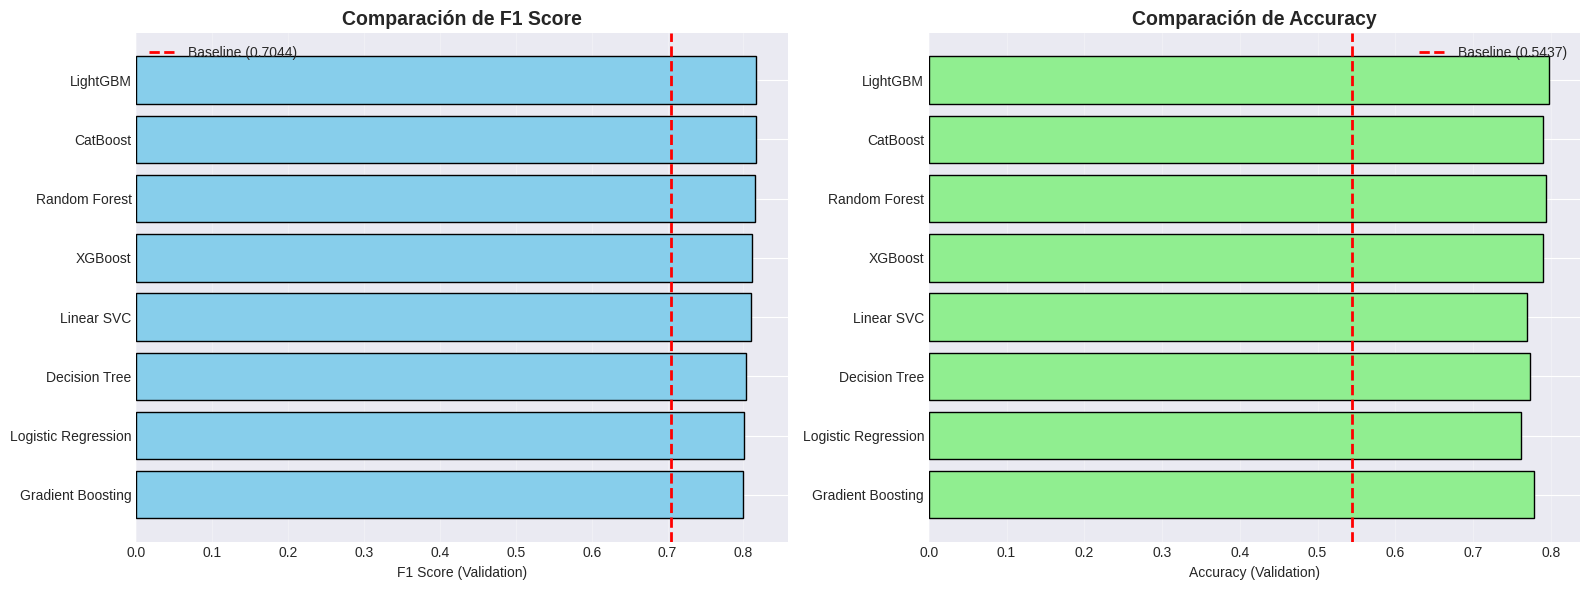

In [31]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: F1 Score
df_results_plot = df_results.sort_values('f1_val')
axes[0].barh(df_results_plot['model'], df_results_plot['f1_val'], color='skyblue', edgecolor='black')
axes[0].axvline(x=f1_baseline, color='red', linestyle='--', linewidth=2, label=f'Baseline ({f1_baseline:.4f})')
axes[0].set_xlabel('F1 Score (Validation)')
axes[0].set_title('Comparación de F1 Score', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Gráfico 2: Accuracy
axes[1].barh(df_results_plot['model'], df_results_plot['acc_val'], color='lightgreen', edgecolor='black')
axes[1].axvline(x=acc_baseline, color='red', linestyle='--', linewidth=2, label=f'Baseline ({acc_baseline:.4f})')
axes[1].set_xlabel('Accuracy (Validation)')
axes[1].set_title('Comparación de Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
## 15. Análisis del Modelo Ganador: LightGBM

#Vamos a analizar en detalle el mejor modelo antes de usarlo en TEST.

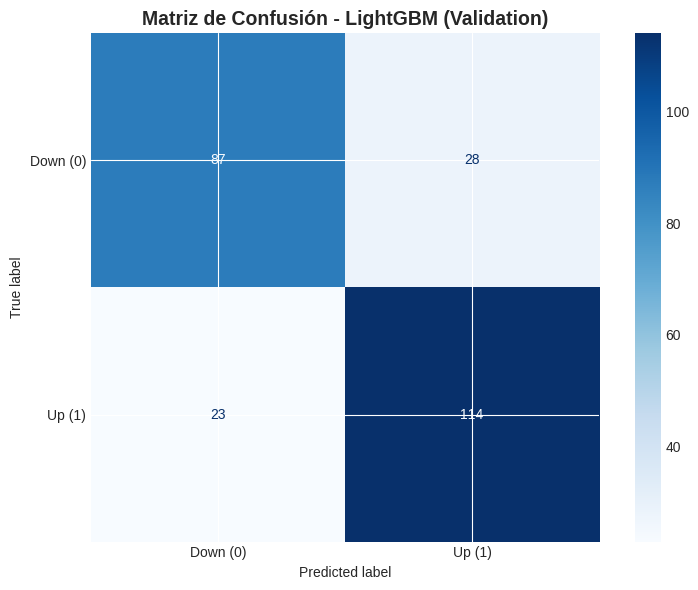

 Interpretación de la Matriz de Confusión:

 True Positives (TP): 114 - Predijo UP y realmente fue UP
 True Negatives (TN): 87 - Predijo DOWN y realmente fue DOWN
 False Positives (FP): 28 - Predijo UP pero fue DOWN (compró mal)
 False Negatives (FN): 23 - Predijo DOWN pero fue UP (perdió oportunidad)


In [32]:
# Matriz de confusión para LightGBM en VALIDATION
from sklearn.metrics import ConfusionMatrixDisplay

y_val_pred_lgbm = model_lgbm.predict(X_val_scaled)

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_val, 
    y_val_pred_lgbm,
    display_labels=['Down (0)', 'Up (1)'],
    cmap='Blues',
    ax=ax
)
ax.set_title('Matriz de Confusión - LightGBM (Validation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretación
print(" Interpretación de la Matriz de Confusión:\n")
cm = confusion_matrix(y_val, y_val_pred_lgbm)
tn, fp, fn, tp = cm.ravel()

print(f" True Positives (TP): {tp} - Predijo UP y realmente fue UP")
print(f" True Negatives (TN): {tn} - Predijo DOWN y realmente fue DOWN")
print(f" False Positives (FP): {fp} - Predijo UP pero fue DOWN (compró mal)")
print(f" False Negatives (FN): {fn} - Predijo DOWN pero fue UP (perdió oportunidad)")

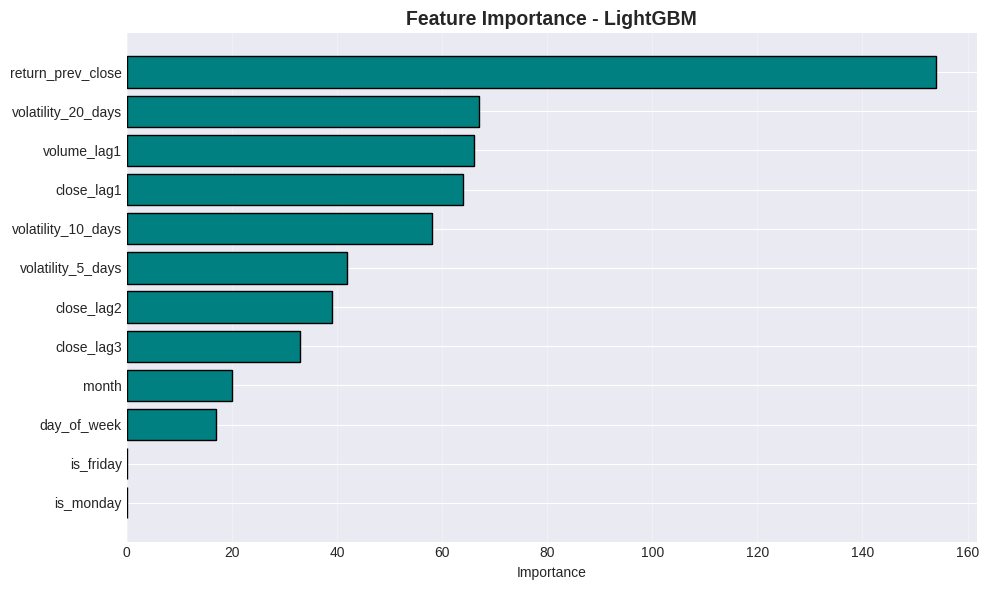


 Top 5 Features más importantes:
              feature  importance
5  volatility_10_days          58
0          close_lag1          64
7         volume_lag1          66
6  volatility_20_days          67
3   return_prev_close         154


In [33]:
# Feature importance
import matplotlib.pyplot as plt

feature_importance = model_lgbm.feature_importances_
features_names = feature_columns

# Crear DataFrame para ordenar
df_importance = pd.DataFrame({
    'feature': features_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(df_importance['feature'], df_importance['importance'], color='teal', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance - LightGBM', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Top 5 Features más importantes:")
print(df_importance.tail(5))

In [34]:
## 16. Reentrenamiento en Train + Validation

#Ahora vamos a reentrenar el modelo LightGBM usando TRAIN + VALIDATION juntos, para tener más datos antes de evaluar en TEST.

In [35]:
# Combinar Train y Validation
X_train_val = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print(f" Dataset combinado TRAIN + VAL:")
print(f"   X_train_val: {X_train_val.shape}")
print(f"   y_train_val: {y_train_val.shape}")
print(f"   % Target=1: {y_train_val.mean()*100:.2f}%")

 Dataset combinado TRAIN + VAL:
   X_train_val: (995, 12)
   y_train_val: (995,)
   % Target=1: 53.97%


In [36]:
# Reentrenar LightGBM con Train+Val
print("\n Reentrenando LightGBM con Train + Validation...\n")

final_model = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_samples=20,
    verbose=-1
)

final_model.fit(X_train_val, y_train_val)

print(" Modelo final entrenado")
print(f"   Datos de entrenamiento: {len(X_train_val):,} registros")


 Reentrenando LightGBM con Train + Validation...

 Modelo final entrenado
   Datos de entrenamiento: 995 registros


In [ ]:
## 17. Evaluación en TEST (2025)



 RESULTADOS EN TEST (2025)

Accuracy:  0.7621 (76.21%)
Precision: 0.7603
Recall:    0.7863
F1 Score:  0.7731
ROC-AUC:   0.8416

 Comparación:
   Baseline F1:  0.7044
   TEST F1:      0.7731
   Mejora:       +6.87%


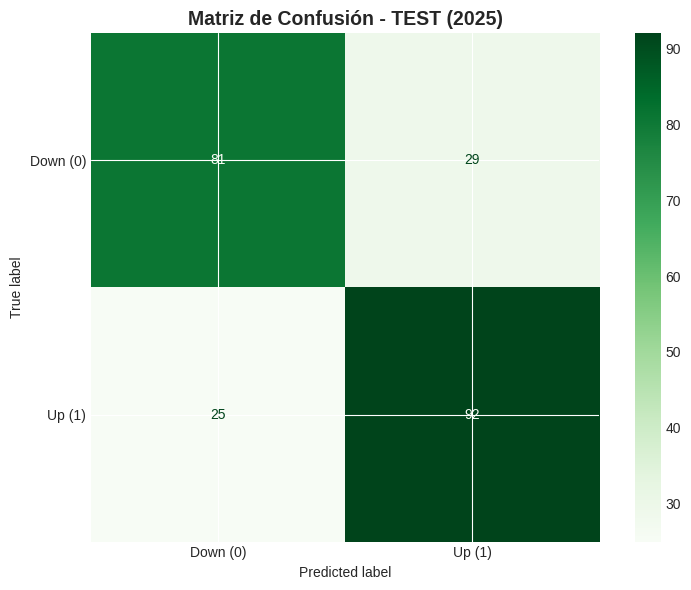

In [37]:
# Predicciones en TEST
y_test_pred = final_model.predict(X_test_scaled)
y_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# Métricas en TEST
acc_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, zero_division=0)
recall_test = recall_score(y_test, y_test_pred, zero_division=0)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_proba)


print(" RESULTADOS EN TEST (2025)")

print(f"\nAccuracy:  {acc_test:.4f} ({acc_test*100:.2f}%)")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1 Score:  {f1_test:.4f}")
print(f"ROC-AUC:   {roc_auc_test:.4f}")

print(f"\n Comparación:")
print(f"   Baseline F1:  {f1_baseline:.4f}")
print(f"   TEST F1:      {f1_test:.4f}")
print(f"   Mejora:       +{(f1_test - f1_baseline)*100:.2f}%")

# Matriz de confusión TEST
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_test_pred,
    display_labels=['Down (0)', 'Up (1)'],
    cmap='Greens',
    ax=ax
)
ax.set_title('Matriz de Confusión - TEST (2025)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
## 18. Simulación de Inversión con $10,000 en 2025



In [38]:
# Preparar datos para simulación
test_df_sim = test_df.copy()
test_df_sim['prediction'] = y_test_pred
test_df_sim['proba_up'] = y_test_proba
test_df_sim['actual'] = y_test.values

# Necesitamos los precios open y close del día
# Cargar desde la base de datos
query_sim = """
SELECT 
    date, ticker, open, close, high, low, volume
FROM analytics.daily_features
WHERE ticker = 'AAPL' AND date > '2024-12-31'
ORDER BY date;
"""
df_prices_2025 = pd.read_sql(query_sim, engine)
df_prices_2025['date'] = pd.to_datetime(df_prices_2025['date'])

# Merge con predicciones
test_df_sim = test_df_sim.merge(
    df_prices_2025[['date', 'open', 'close']], 
    on='date', 
    how='left'
)

print(f" Datos de simulación preparados: {len(test_df_sim)} días")
display(test_df_sim[['date', 'open', 'close', 'prediction', 'proba_up', 'actual']].head(10))

 Datos de simulación preparados: 227 días


,date,open,close,prediction,proba_up,actual
0,2025-01-02,247.8092,242.7521,0,0.015782,0
1,2025-01-03,242.2643,242.2643,0,0.245815,0
2,2025-01-06,243.2100,243.8969,1,0.647487,1
3,2025-01-07,241.8860,241.1195,0,0.070797,0
4,2025-01-08,240.8308,241.6073,1,0.620171,1
5,2025-01-10,238.9294,235.7836,0,0.021488,0
6,2025-01-13,232.4785,233.3446,0,0.116407,1
7,2025-01-14,233.6931,232.2297,0,0.183725,0
8,2025-01-15,233.5835,236.7990,1,0.830432,1
9,2025-01-16,236.2814,227.2323,0,0.010601,0


In [43]:
# Simulación de trading
capital_inicial = 10000
capital = capital_inicial
cash = capital_inicial
shares = 0
trades = []

print(f" Simulación de Trading - Capital inicial: ${capital_inicial:,.2f}\n")

for idx, row in test_df_sim.iterrows():
    date = row['date']
    open_price = row['open']
    close_price = row['close']
    prediction = row['prediction']
    actual = row['actual']
    
    # Estrategia: Si predice UP, comprar en open y vender en close
    if prediction == 1:  # Predice UP
        # Comprar al open (invertir todo el cash)
        shares_to_buy = cash / open_price
        shares += shares_to_buy
        cash = 0
        
        # Vender al close
        cash = shares * close_price
        
        # Calcular ganancia/pérdida del día
        daily_return = (close_price - open_price) / open_price
        daily_pnl = shares_to_buy * (close_price - open_price)
        
        shares = 0  # Vendimos todo
        
        trades.append({
            'date': date,
            'action': 'BUY-SELL',
            'open': open_price,
            'close': close_price,
            'shares': shares_to_buy,
            'daily_return': daily_return,
            'pnl': daily_pnl,
            'capital': cash,
            'prediction': prediction,
            'actual': actual,
            'correct': prediction == actual
        })
    else:
        # No operar, mantenerse en cash
        trades.append({
            'date': date,
            'action': 'HOLD',
            'open': open_price,
            'close': close_price,
            'shares': 0,
            'daily_return': 0,
            'pnl': 0,
            'capital': cash,
            'prediction': prediction,
            'actual': actual,
            'correct': prediction == actual
        })

# Capital final
capital_final = cash
retorno_total = (capital_final - capital_inicial) / capital_inicial
trades_ejecutados = len([t for t in trades if t['action'] == 'BUY-SELL'])
trades_correctos = len([t for t in trades if t['action'] == 'BUY-SELL' and t['correct']])
trades_incorrectos = trades_ejecutados - trades_correctos

print(f" RESULTADOS DE LA SIMULACIÓN")
print(f" Capital inicial:  ${capital_inicial:,.2f}")
print(f" Capital final:    ${capital_final:,.2f}")
print(f" Ganancia/Pérdida: ${capital_final - capital_inicial:,.2f}")
print(f" Retorno total:    {retorno_total*100:.2f}%")
print(f"\n Trades ejecutados: {trades_ejecutados} de {len(trades)} días")
print(f"    Correctos:   {trades_correctos} ({trades_correctos/trades_ejecutados*100:.1f}%)")
print(f"    Incorrectos: {trades_incorrectos} ({trades_incorrectos/trades_ejecutados*100:.1f}%)")

# Crear DataFrame de trades
df_trades = pd.DataFrame(trades)

 Simulación de Trading - Capital inicial: $10,000.00

 RESULTADOS DE LA SIMULACIÓN
 Capital inicial:  $10,000.00
 Capital final:    $28,862.37
 Ganancia/Pérdida: $18,862.37
 Retorno total:    188.62%

 Trades ejecutados: 121 de 227 días
    Correctos:   92 (76.0%)
    Incorrectos: 29 (24.0%)


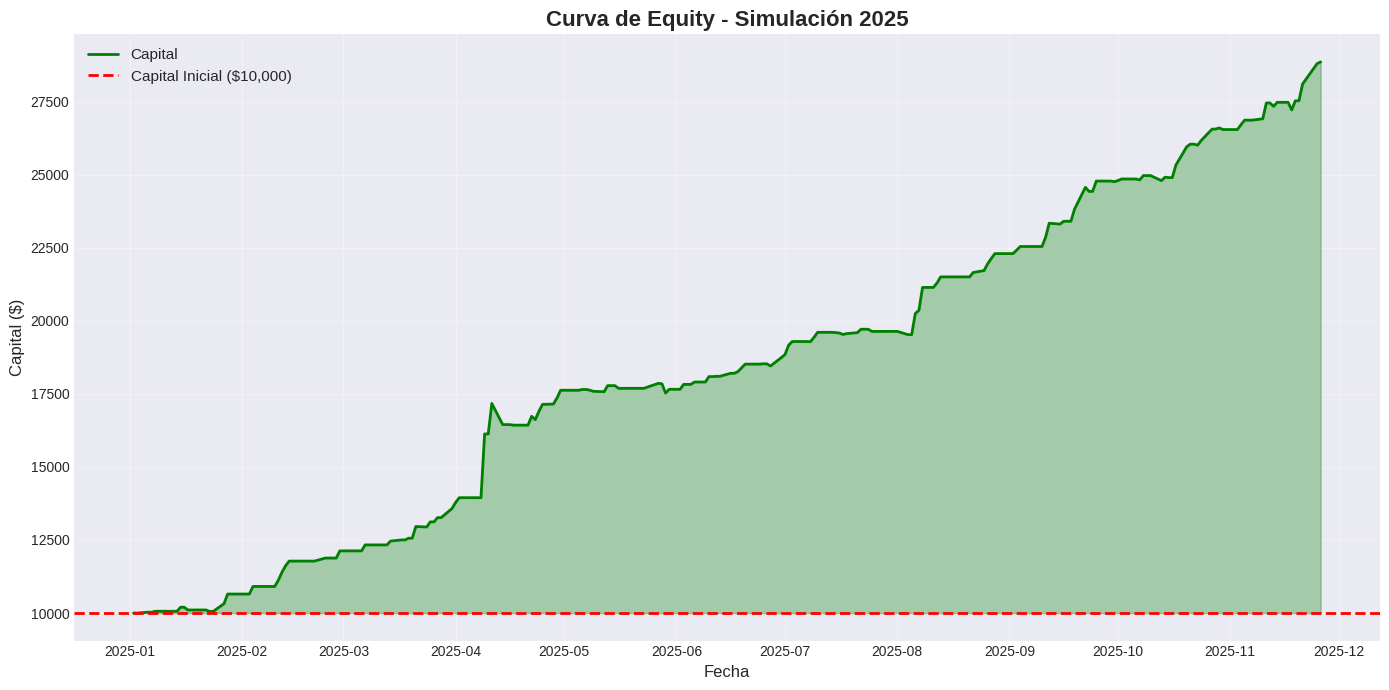


 Estadísticas de la curva:
   Máximo capital: $28,862.37
   Mínimo capital: $10,000.00
   Drawdown máximo: 0.00%


In [41]:
# Visualización de la curva de equity
df_trades['date'] = pd.to_datetime(df_trades['date'])
df_trades = df_trades.sort_values('date')

plt.figure(figsize=(14, 7))
plt.plot(df_trades['date'], df_trades['capital'], linewidth=2, color='green', label='Capital')
plt.axhline(y=capital_inicial, color='red', linestyle='--', linewidth=2, label=f'Capital Inicial (${capital_inicial:,.0f})')
plt.fill_between(df_trades['date'], capital_inicial, df_trades['capital'], alpha=0.3, color='green')

plt.title('Curva de Equity - Simulación 2025', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n Estadísticas de la curva:")
print(f"   Máximo capital: ${df_trades['capital'].max():,.2f}")
print(f"   Mínimo capital: ${df_trades['capital'].min():,.2f}")
print(f"   Drawdown máximo: {((df_trades['capital'].min() - capital_inicial) / capital_inicial * 100):.2f}%")

In [ ]:
## 19. Tuning de Hiperparámetros con GridSearchCV



In [45]:
from sklearn.model_selection import GridSearchCV

print(" Tuning de Hiperparámetros - LightGBM\n")


# Definir grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 50]
}

print(f" Grid de búsqueda:")
print(f"   Combinaciones totales: {np.prod([len(v) for v in param_grid.values()])}")
print(f"   Parámetros a tunear: {list(param_grid.keys())}\n")

# Modelo base
lgbm_base = LGBMClassifier(random_state=42, verbose=-1)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm_base,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation temporal
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar
print(" Iniciando búsqueda de hiperparámetros...\n")
start_time = datetime.now()

grid_search.fit(X_train_scaled, y_train)

duration = (datetime.now() - start_time).total_seconds()

print(f"\n GridSearch completado en {duration:.2f}s")
print(f"\n Mejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n Mejor F1 (CV): {grid_search.best_score_:.4f}")

 Tuning de Hiperparámetros - LightGBM

 Grid de búsqueda:
   Combinaciones totales: 243
   Parámetros a tunear: ['n_estimators', 'learning_rate', 'max_depth', 'min_child_samples', 'num_leaves']

 Iniciando búsqueda de hiperparámetros...

Fitting 3 folds for each of 243 candidates, totalling 729 fits

 GridSearch completado en 509.30s

 Mejores hiperparámetros encontrados:
   learning_rate: 0.05
   max_depth: 3
   min_child_samples: 20
   n_estimators: 50
   num_leaves: 15

 Mejor F1 (CV): 0.8520


In [46]:
# Evaluar modelo tuneado en validación
best_model = grid_search.best_estimator_

y_val_pred_tuned = best_model.predict(X_val_scaled)
y_val_proba_tuned = best_model.predict_proba(X_val_scaled)[:, 1]

# Métricas
acc_val_tuned = accuracy_score(y_val, y_val_pred_tuned)
f1_val_tuned = f1_score(y_val, y_val_pred_tuned)
roc_auc_val_tuned = roc_auc_score(y_val, y_val_proba_tuned)

print(" COMPARACIÓN: Modelo Original vs Tuneado")
print(f"\n{'Métrica':<20} {'Original':<15} {'Tuneado':<15} {'Mejora'}")
print(f"{'Accuracy VAL':<20} {0.7976:<15.4f} {acc_val_tuned:<15.4f} {(acc_val_tuned-0.7976)*100:+.2f}%")
print(f"{'F1 VAL':<20} {0.8172:<15.4f} {f1_val_tuned:<15.4f} {(f1_val_tuned-0.8172)*100:+.2f}%")
print(f"{'ROC-AUC VAL':<20} {0.8468:<15.4f} {roc_auc_val_tuned:<15.4f} {(roc_auc_val_tuned-0.8468)*100:+.2f}%")

if f1_val_tuned > 0.8172:
    print("\n El tuning mejoró el modelo")
    final_model_tuned = best_model
else:
    print("\n  El modelo original era mejor, lo mantenemos")
    final_model_tuned = model_lgbm

 COMPARACIÓN: Modelo Original vs Tuneado

Métrica              Original        Tuneado         Mejora
Accuracy VAL         0.7976          0.7778          -1.98%
F1 VAL               0.8172          0.8082          -0.90%
ROC-AUC VAL          0.8468          0.8677          +2.09%

  El modelo original era mejor, lo mantenemos


In [47]:
# Reentrenar el mejor modelo con Train+Val
print("\n Reentrenando modelo tuneado con Train+Val...\n")

# Usar los mejores hiperparámetros
final_model_tuned = LGBMClassifier(
    **grid_search.best_params_,
    random_state=42,
    verbose=-1
)

final_model_tuned.fit(X_train_val, y_train_val)

print(" Modelo final tuneado entrenado")
print(f"   Hiperparámetros: {grid_search.best_params_}")


 Reentrenando modelo tuneado con Train+Val...

 Modelo final tuneado entrenado
   Hiperparámetros: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 50, 'num_leaves': 15}


In [48]:
# Evaluar en TEST con modelo tuneado
y_test_pred_tuned = final_model_tuned.predict(X_test_scaled)
y_test_proba_tuned = final_model_tuned.predict_proba(X_test_scaled)[:, 1]

acc_test_tuned = accuracy_score(y_test, y_test_pred_tuned)
f1_test_tuned = f1_score(y_test, y_test_pred_tuned)
roc_auc_test_tuned = roc_auc_score(y_test, y_test_proba_tuned)

print(" RESULTADOS FINALES EN TEST (Modelo Tuneado)")
print(f"\nAccuracy:  {acc_test_tuned:.4f} ({acc_test_tuned*100:.2f}%)")
print(f"Precision: {precision_score(y_test, y_test_pred_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_tuned):.4f}")
print(f"F1 Score:  {f1_test_tuned:.4f}")
print(f"ROC-AUC:   {roc_auc_test_tuned:.4f}")

print(f"\nComparación vs modelo sin tuning:")
print(f"   F1 anterior: {f1_test:.4f}")
print(f"   F1 tuneado:  {f1_test_tuned:.4f}")
print(f"   Mejora:      {(f1_test_tuned - f1_test)*100:+.2f}%")

 RESULTADOS FINALES EN TEST (Modelo Tuneado)

Accuracy:  0.7974 (79.74%)
Precision: 0.7630
Recall:    0.8803
F1 Score:  0.8175
ROC-AUC:   0.8582

Comparación vs modelo sin tuning:
   F1 anterior: 0.7731
   F1 tuneado:  0.8175
   Mejora:      +4.44%


In [ ]:
## 20. Análisis de Errores



In [49]:
# Preparar datos de errores
test_df_errors = test_df.copy()
test_df_errors['prediction'] = y_test_pred_tuned
test_df_errors['actual'] = y_test.values
test_df_errors['correct'] = test_df_errors['prediction'] == test_df_errors['actual']
test_df_errors['error_type'] = 'Correct'

# Clasificar errores
test_df_errors.loc[
    (test_df_errors['prediction'] == 1) & (test_df_errors['actual'] == 0), 
    'error_type'
] = 'False Positive (predijo UP, fue DOWN)'

test_df_errors.loc[
    (test_df_errors['prediction'] == 0) & (test_df_errors['actual'] == 1), 
    'error_type'
] = 'False Negative (predijo DOWN, fue UP)'

print(" ANÁLISIS DE ERRORES\n")
print("\n Distribución de errores:")
print(test_df_errors['error_type'].value_counts())

# Estadísticas por tipo de error
print("\n Características de los errores:\n")

for error_type in ['False Positive (predijo UP, fue DOWN)', 'False Negative (predijo DOWN, fue UP)']:
    if error_type in test_df_errors['error_type'].values:
        df_error = test_df_errors[test_df_errors['error_type'] == error_type]
        
        print(f"{error_type}:")
        print(f"   Cantidad: {len(df_error)}")
        print(f"   Volatilidad promedio: {df_error['volatility_20_days'].mean():.6f}")
        print(f"   Retorno previo promedio: {df_error['return_prev_close'].mean():.6f}")
        print()

 ANÁLISIS DE ERRORES


 Distribución de errores:
error_type
Correct                                  181
False Positive (predijo UP, fue DOWN)     32
False Negative (predijo DOWN, fue UP)     14
Name: count, dtype: int64

 Características de los errores:

False Positive (predijo UP, fue DOWN):
   Cantidad: 32
   Volatilidad promedio: 0.019365
   Retorno previo promedio: 0.006107

False Negative (predijo DOWN, fue UP):
   Cantidad: 14
   Volatilidad promedio: 0.020600
   Retorno previo promedio: -0.012306



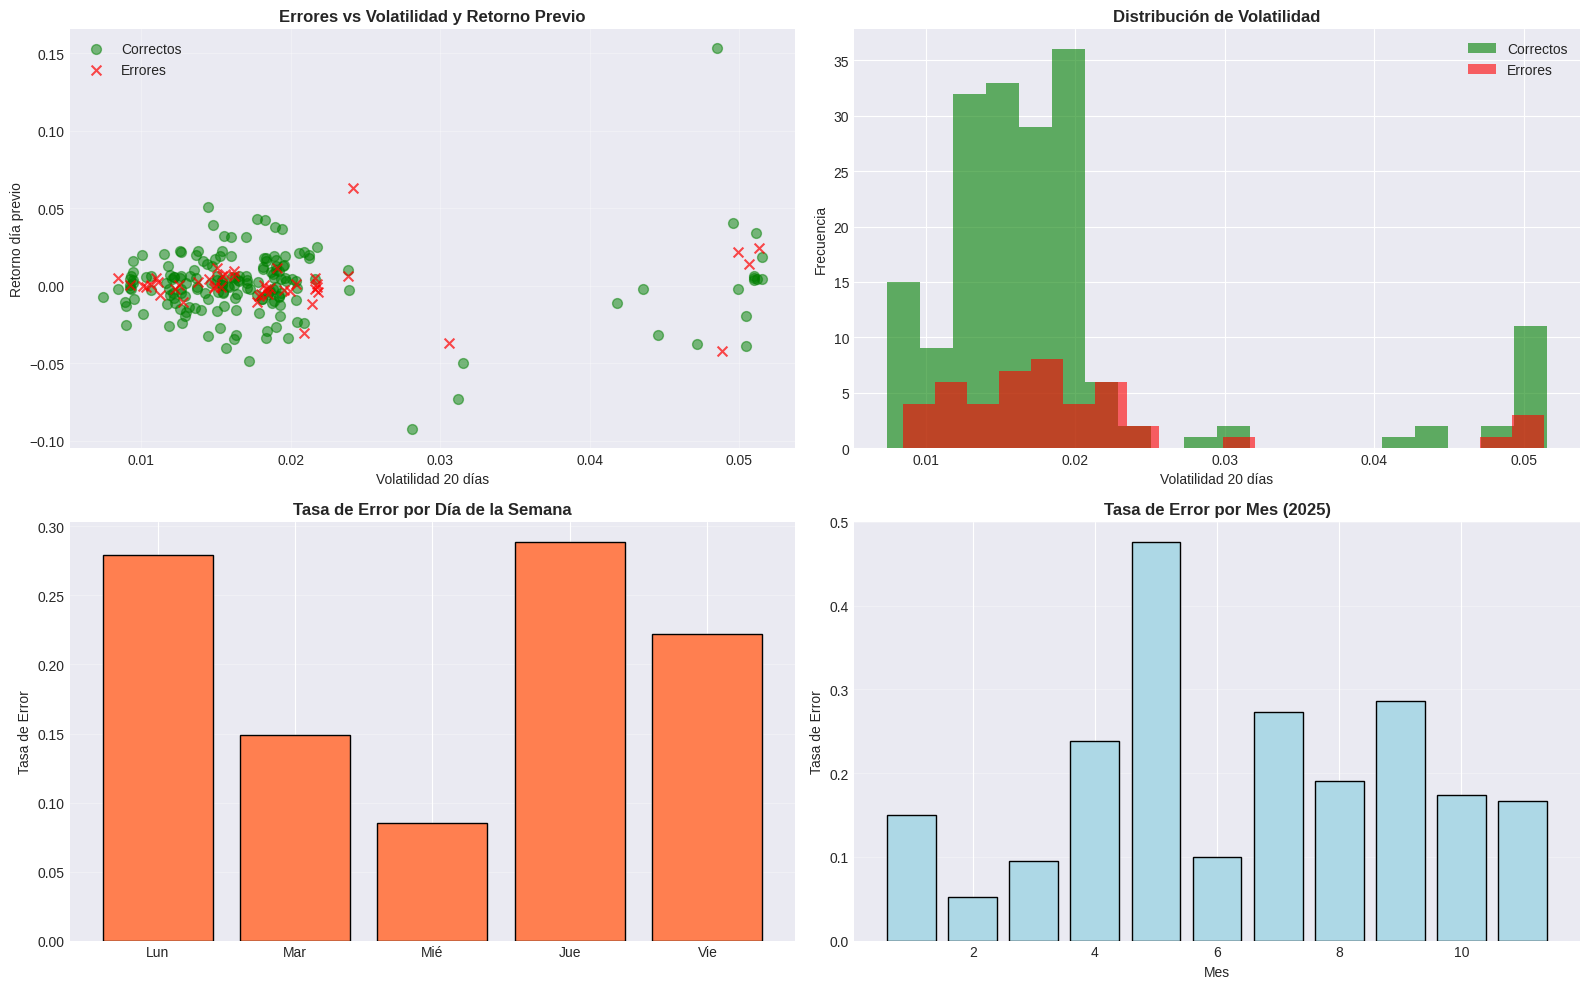

In [50]:
# Visualización de errores
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Errores por volatilidad
axes[0, 0].scatter(
    test_df_errors[test_df_errors['correct']]['volatility_20_days'],
    test_df_errors[test_df_errors['correct']]['return_prev_close'],
    c='green', alpha=0.5, label='Correctos', s=50
)
axes[0, 0].scatter(
    test_df_errors[~test_df_errors['correct']]['volatility_20_days'],
    test_df_errors[~test_df_errors['correct']]['return_prev_close'],
    c='red', alpha=0.7, label='Errores', s=50, marker='x'
)
axes[0, 0].set_xlabel('Volatilidad 20 días')
axes[0, 0].set_ylabel('Retorno día previo')
axes[0, 0].set_title('Errores vs Volatilidad y Retorno Previo', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Distribución de volatilidad en errores
test_df_errors[test_df_errors['correct']]['volatility_20_days'].hist(
    bins=20, alpha=0.6, color='green', label='Correctos', ax=axes[0, 1]
)
test_df_errors[~test_df_errors['correct']]['volatility_20_days'].hist(
    bins=20, alpha=0.6, color='red', label='Errores', ax=axes[0, 1]
)
axes[0, 1].set_xlabel('Volatilidad 20 días')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Volatilidad', fontweight='bold')
axes[0, 1].legend()

# 3. Errores por día de la semana
error_by_day = test_df_errors.groupby('day_of_week')['correct'].agg(['sum', 'count'])
error_by_day['error_rate'] = 1 - (error_by_day['sum'] / error_by_day['count'])
days_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie']
axes[1, 0].bar(days_names, error_by_day['error_rate'], color='coral', edgecolor='black')
axes[1, 0].set_ylabel('Tasa de Error')
axes[1, 0].set_title('Tasa de Error por Día de la Semana', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Errores por mes
error_by_month = test_df_errors.groupby('month')['correct'].agg(['sum', 'count'])
error_by_month['error_rate'] = 1 - (error_by_month['sum'] / error_by_month['count'])
axes[1, 1].bar(error_by_month.index, error_by_month['error_rate'], color='lightblue', edgecolor='black')
axes[1, 1].set_xlabel('Mes')
axes[1, 1].set_ylabel('Tasa de Error')
axes[1, 1].set_title('Tasa de Error por Mes (2025)', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
# Conclusiones del análisis de errores
print("\n CONCLUSIONES DEL ANÁLISIS DE ERRORES:\n")

# Volatilidad
vol_correct = test_df_errors[test_df_errors['correct']]['volatility_20_days'].mean()
vol_incorrect = test_df_errors[~test_df_errors['correct']]['volatility_20_days'].mean()

if vol_incorrect > vol_correct:
    print("1.  El modelo falla más en días de ALTA volatilidad")
    print(f"   Volatilidad promedio en aciertos: {vol_correct:.6f}")
    print(f"   Volatilidad promedio en errores:  {vol_incorrect:.6f}")
else:
    print("1.  La volatilidad NO es un factor determinante en los errores")

# Día de la semana
worst_day = error_by_day['error_rate'].idxmax()
print(f"\n2.  Día con más errores: {days_names[worst_day]} (tasa de error: {error_by_day['error_rate'].iloc[worst_day]:.2%})")

# Tipo de error más común
error_counts = test_df_errors['error_type'].value_counts()
most_common_error = error_counts.index[1] if len(error_counts) > 1 else "N/A"
print(f"\n3.  Error más común: {most_common_error}")




 CONCLUSIONES DEL ANÁLISIS DE ERRORES:

1.  El modelo falla más en días de ALTA volatilidad
   Volatilidad promedio en aciertos: 0.018777
   Volatilidad promedio en errores:  0.019741

2.  Día con más errores: Jue (tasa de error: 28.89%)

3.  Error más común: False Positive (predijo UP, fue DOWN)


In [52]:
# RE-SIMULACIÓN con modelo tuneado
test_df_sim_tuned = test_df.copy()
test_df_sim_tuned['prediction'] = y_test_pred_tuned
test_df_sim_tuned['proba_up'] = y_test_proba_tuned
test_df_sim_tuned['actual'] = y_test.values

# Merge con precios
test_df_sim_tuned = test_df_sim_tuned.merge(
    df_prices_2025[['date', 'open', 'close']], 
    on='date', 
    how='left'
)

# Simulación
capital_inicial = 10000
capital = capital_inicial
cash = capital_inicial
shares = 0
trades_tuned = []

for idx, row in test_df_sim_tuned.iterrows():
    date = row['date']
    open_price = row['open']
    close_price = row['close']
    prediction = row['prediction']
    actual = row['actual']
    
    if prediction == 1:
        shares_to_buy = cash / open_price
        shares += shares_to_buy
        cash = 0
        
        cash = shares * close_price
        daily_return = (close_price - open_price) / open_price
        daily_pnl = shares_to_buy * (close_price - open_price)
        shares = 0
        
        trades_tuned.append({
            'date': date,
            'action': 'BUY-SELL',
            'open': open_price,
            'close': close_price,
            'shares': shares_to_buy,
            'daily_return': daily_return,
            'pnl': daily_pnl,
            'capital': cash,
            'prediction': prediction,
            'actual': actual,
            'correct': prediction == actual
        })
    else:
        trades_tuned.append({
            'date': date,
            'action': 'HOLD',
            'open': open_price,
            'close': close_price,
            'shares': 0,
            'daily_return': 0,
            'pnl': 0,
            'capital': cash,
            'prediction': prediction,
            'actual': actual,
            'correct': prediction == actual
        })

capital_final_tuned = cash
retorno_total_tuned = (capital_final_tuned - capital_inicial) / capital_inicial
trades_ejecutados_tuned = len([t for t in trades_tuned if t['action'] == 'BUY-SELL'])
trades_correctos_tuned = len([t for t in trades_tuned if t['action'] == 'BUY-SELL' and t['correct']])

print(" RE-SIMULACIÓN CON MODELO TUNEADO")
print(f"\n Capital inicial:  ${capital_inicial:,.2f}")
print(f" Capital final:    ${capital_final_tuned:,.2f}")
print(f" Ganancia/Pérdida: ${capital_final_tuned - capital_inicial:,.2f}")
print(f" Retorno total:    {retorno_total_tuned*100:.2f}%")
print(f"\n Trades ejecutados: {trades_ejecutados_tuned} de {len(trades_tuned)} días")
print(f"    Correctos:   {trades_correctos_tuned} ({trades_correctos_tuned/trades_ejecutados_tuned*100:.1f}%)")
print(f"    Incorrectos: {trades_ejecutados_tuned - trades_correctos_tuned}")

print(f"\nCOMPARACIÓN:")
print(f"   Modelo sin tuning: ${28862.37:,.2f} (+188.62%)")
print(f"   Modelo tuneado:    ${capital_final_tuned:,.2f} (+{retorno_total_tuned*100:.2f}%)")
print(f"   Diferencia:        ${capital_final_tuned - 28862.37:,.2f}")

 RE-SIMULACIÓN CON MODELO TUNEADO

 Capital inicial:  $10,000.00
 Capital final:    $31,798.37
 Ganancia/Pérdida: $21,798.37
 Retorno total:    217.98%

 Trades ejecutados: 135 de 227 días
    Correctos:   103 (76.3%)
    Incorrectos: 32

COMPARACIÓN:
   Modelo sin tuning: $28,862.37 (+188.62%)
   Modelo tuneado:    $31,798.37 (+217.98%)
   Diferencia:        $2,936.00


In [ ]:
## 21. Exportar Modelo para Producción

In [53]:
import joblib
import os

# Crear carpeta models si no existe
os.makedirs('../models', exist_ok=True)

print(" Guardando modelo y componentes del pipeline...\n")

# 1. Guardar el modelo final tuneado
model_path = '../models/best_model.pkl'
joblib.dump(final_model_tuned, model_path)
print(f" Modelo guardado en: {model_path}")

# 2. Guardar el scaler
scaler_path = '../models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f" Scaler guardado en: {scaler_path}")

# 3. Guardar el imputer
imputer_path = '../models/imputer.pkl'
joblib.dump(imputer, imputer_path)
print(f" Imputer guardado en: {imputer_path}")

# 4. Guardar lista de features
features_path = '../models/feature_columns.pkl'
joblib.dump(feature_columns, features_path)
print(f" Features guardadas en: {features_path}")

# 5. Guardar metadata del modelo
metadata = {
    'model_name': 'LightGBM',
    'model_type': 'LGBMClassifier',
    'target': 'target_up',
    'ticker': 'AAPL',
    'features': feature_columns,
    'hiperparametros': grid_search.best_params_,
    'metricas_test': {
        'accuracy': float(acc_test_tuned),
        'f1': float(f1_test_tuned),
        'roc_auc': float(roc_auc_test_tuned),
        'precision': float(precision_score(y_test, y_test_pred_tuned)),
        'recall': float(recall_score(y_test, y_test_pred_tuned))
    },
    'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'train_size': len(X_train_val),
    'test_size': len(X_test)
}

metadata_path = '../models/model_metadata.pkl'
joblib.dump(metadata, metadata_path)
print(f" Metadata guardada en: {metadata_path}")

print(" TODOS LOS COMPONENTES GUARDADOS EXITOSAMENTE")


 Guardando modelo y componentes del pipeline...

 Modelo guardado en: ../models/best_model.pkl
 Scaler guardado en: ../models/scaler.pkl
 Imputer guardado en: ../models/imputer.pkl
 Features guardadas en: ../models/feature_columns.pkl
 Metadata guardada en: ../models/model_metadata.pkl
 TODOS LOS COMPONENTES GUARDADOS EXITOSAMENTE


In [54]:
# Verificar que se puede cargar correctamente
print("\n Verificando carga del modelo...\n")

try:
    # Cargar modelo
    loaded_model = joblib.load(model_path)
    loaded_scaler = joblib.load(scaler_path)
    loaded_imputer = joblib.load(imputer_path)
    loaded_features = joblib.load(features_path)
    loaded_metadata = joblib.load(metadata_path)
    
    print(" Modelo cargado correctamente")
    print(" Scaler cargado correctamente")
    print(" Imputer cargado correctamente")
    print(" Features cargadas correctamente")
    print(" Metadata cargada correctamente")
    
    # Probar predicción
    sample = X_test_scaled.iloc[0:1]
    prediction = loaded_model.predict(sample)
    proba = loaded_model.predict_proba(sample)
    
    print(f"\n Prueba de predicción:")
    print(f"   Input shape: {sample.shape}")
    print(f"   Predicción: {prediction[0]} ({'UP' if prediction[0] == 1 else 'DOWN'})")
    print(f"   Probabilidad UP: {proba[0][1]:.4f}")
    
    print("\n Modelo funcional y listo para API")
    
except Exception as e:
    print(f" Error al cargar modelo: {e}")


 Verificando carga del modelo...

 Modelo cargado correctamente
 Scaler cargado correctamente
 Imputer cargado correctamente
 Features cargadas correctamente
 Metadata cargada correctamente

 Prueba de predicción:
   Input shape: (1, 12)
   Predicción: 0 (DOWN)
   Probabilidad UP: 0.1062

 Modelo funcional y listo para API


In [ ]:
## 22. API REST con Flask

In [58]:
# Mostrar el código de app.py para que lo copies manualmente
app_code = '''#!/usr/bin/env python3
"""
API REST para predicción de movimientos de precio de AAPL
Endpoint: POST /predict
"""

from flask import Flask, request, jsonify
import joblib
import numpy as np
import pandas as pd
import os
from datetime import datetime

app = Flask(__name__)

# Configuración
MODEL_PATH = os.getenv('MODEL_PATH', '/app/models/best_model.pkl')
SCALER_PATH = '/app/models/scaler.pkl'
IMPUTER_PATH = '/app/models/imputer.pkl'
FEATURES_PATH = '/app/models/feature_columns.pkl'
METADATA_PATH = '/app/models/model_metadata.pkl'

# Cargar modelo y componentes al inicio
print(" Cargando modelo...")
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
imputer = joblib.load(IMPUTER_PATH)
feature_columns = joblib.load(FEATURES_PATH)
metadata = joblib.load(METADATA_PATH)
print(" Modelo cargado exitosamente")


@app.route('/', methods=['GET'])
def home():
    """Endpoint raíz con información del modelo"""
    return jsonify({
        'status': 'online',
        'model': metadata['model_name'],
        'ticker': metadata['ticker'],
        'features': metadata['features'],
        'metricas_test': metadata['metricas_test'],
        'fecha_entrenamiento': metadata['fecha_entrenamiento'],
        'endpoints': {
            'predict': '/predict (POST)',
            'health': '/health (GET)',
            'model_info': '/model_info (GET)'
        }
    })


@app.route('/health', methods=['GET'])
def health():
    """Health check endpoint"""
    return jsonify({
        'status': 'healthy',
        'timestamp': datetime.now().isoformat()
    })


@app.route('/model_info', methods=['GET'])
def model_info():
    """Información detallada del modelo"""
    return jsonify(metadata)


@app.route('/predict', methods=['POST'])
def predict():
    """
    Endpoint principal de predicción
    
    Input JSON:
    {
        "close_lag1": 180.5,
        "close_lag2": 179.2,
        "close_lag3": 178.8,
        "return_prev_close": 0.005,
        "volatility_5_days": 0.02,
        "volatility_10_days": 0.018,
        "volatility_20_days": 0.019,
        "volume_lag1": 50000000,
        "day_of_week": 0,
        "month": 1,
        "is_monday": true,
        "is_friday": false
    }
    
    Output JSON:
    {
        "prediction": 1,
        "prediction_label": "UP",
        "probability_up": 0.75,
        "probability_down": 0.25,
        "confidence": "high",
        "timestamp": "2025-01-15T10:30:00"
    }
    """
    try:
        # Obtener datos del request
        data = request.get_json()
        
        if not data:
            return jsonify({
                'error': 'No se proporcionaron datos',
                'example': {feat: 0.0 for feat in feature_columns}
            }), 400
        
        # Validar que todas las features estén presentes
        missing_features = [f for f in feature_columns if f not in data]
        if missing_features:
            return jsonify({
                'error': f'Features faltantes: {missing_features}',
                'required_features': feature_columns
            }), 400
        
        # Crear DataFrame con las features en el orden correcto
        input_df = pd.DataFrame([data])[feature_columns]
        
        # Preprocesar (imputar + escalar)
        input_imputed = imputer.transform(input_df)
        input_scaled = scaler.transform(input_imputed)
        
        # Predicción
        prediction = int(model.predict(input_scaled)[0])
        probabilities = model.predict_proba(input_scaled)[0]
        prob_down = float(probabilities[0])
        prob_up = float(probabilities[1])
        
        # Determinar confianza
        confidence = 'high' if max(prob_up, prob_down) > 0.7 else 'medium' if max(prob_up, prob_down) > 0.55 else 'low'
        
        # Respuesta
        response = {
            'prediction': prediction,
            'prediction_label': 'UP' if prediction == 1 else 'DOWN',
            'probability_up': round(prob_up, 4),
            'probability_down': round(prob_down, 4),
            'confidence': confidence,
            'recommendation': 'BUY at open, SELL at close' if prediction == 1 else 'HOLD (stay in cash)',
            'timestamp': datetime.now().isoformat(),
            'model': metadata['model_name'],
            'ticker': metadata['ticker']
        }
        
        return jsonify(response), 200
        
    except Exception as e:
        return jsonify({
            'error': str(e),
            'type': type(e).__name__
        }), 500


if __name__ == '__main__':
    port = int(os.getenv('API_PORT', 5000))
    app.run(host='0.0.0.0', port=port, debug=False)
'''


print(app_code)





#!/usr/bin/env python3
"""
API REST para predicción de movimientos de precio de AAPL
Endpoint: POST /predict
"""

from flask import Flask, request, jsonify
import joblib
import numpy as np
import pandas as pd
import os
from datetime import datetime

app = Flask(__name__)

# Configuración
MODEL_PATH = os.getenv('MODEL_PATH', '/app/models/best_model.pkl')
SCALER_PATH = '/app/models/scaler.pkl'
IMPUTER_PATH = '/app/models/imputer.pkl'
FEATURES_PATH = '/app/models/feature_columns.pkl'
METADATA_PATH = '/app/models/model_metadata.pkl'

# Cargar modelo y componentes al inicio
print(" Cargando modelo...")
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
imputer = joblib.load(IMPUTER_PATH)
feature_columns = joblib.load(FEATURES_PATH)
metadata = joblib.load(METADATA_PATH)
print(" Modelo cargado exitosamente")


@app.route('/', methods=['GET'])
def home():
    """Endpoint raíz con información del modelo"""
    return jsonify({
        'status': 'online',
        'model': metadata

In [59]:
# Actualizar requirements.txt de model_api
requirements = '''flask==2.3.2
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
lightgbm==4.1.0
joblib==1.3.1
python-dotenv==1.0.0'''

# Mostrar para copiar manualmente
print(" Copia el siguiente contenido y guárdalo en:")
print("   model_api/requirements.txt")
print(requirements)


 Copia el siguiente contenido y guárdalo en:
   model_api/requirements.txt
flask==2.3.2
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
lightgbm==4.1.0
joblib==1.3.1
python-dotenv==1.0.0


In [62]:
import requests
import json

# IMPORTANTE: Desde Jupyter (dentro de Docker) usar el nombre del servicio
API_URL = "http://model-api:5000"

print(" PROBANDO LA API\n")

try:
    # Test 1: Health check
    print("\n Health Check:")
    response = requests.get(f"{API_URL}/health", timeout=5)
    print(f"   Status: {response.status_code}")
    print(f"   Response: {response.json()}")

    # Test 2: Info del modelo
    print("\n Información del Modelo:")
    response = requests.get(f"{API_URL}/model_info", timeout=5)
    print(f"   Status: {response.status_code}")
    model_info = response.json()
    print(f"   Modelo: {model_info['model_name']}")
    print(f"   Ticker: {model_info['ticker']}")
    print(f"   F1 Test: {model_info['metricas_test']['f1']:.4f}")

    # Test 3: Predicción con datos reales del último día de test
    print("\n Predicción con datos reales:")

    # Tomar el último día de test como ejemplo
    ultimo_dia = test_df.iloc[-1]

    payload = {
        'close_lag1': float(ultimo_dia['close_lag1']),
        'close_lag2': float(ultimo_dia['close_lag2']),
        'close_lag3': float(ultimo_dia['close_lag3']),
        'return_prev_close': float(ultimo_dia['return_prev_close']),
        'volatility_5_days': float(ultimo_dia['volatility_5_days']),
        'volatility_10_days': float(ultimo_dia['volatility_10_days']),
        'volatility_20_days': float(ultimo_dia['volatility_20_days']),
        'volume_lag1': int(ultimo_dia['volume_lag1']),
        'day_of_week': int(ultimo_dia['day_of_week']),
        'month': int(ultimo_dia['month']),
        'is_monday': bool(ultimo_dia['is_monday']),
        'is_friday': bool(ultimo_dia['is_friday'])
    }

    print(f"\n    Fecha: {ultimo_dia['date']}")
    print(f"    Input (primeros 4 features):")
    print(f"      close_lag1: {payload['close_lag1']}")
    print(f"      close_lag2: {payload['close_lag2']}")
    print(f"      return_prev_close: {payload['return_prev_close']}")
    print(f"      volatility_20_days: {payload['volatility_20_days']}")

    response = requests.post(f"{API_URL}/predict", json=payload, timeout=5)
    print(f"\n   Status: {response.status_code}")

    if response.status_code == 200:
        prediction = response.json()
        print(f"\n    Respuesta:")
        print(f"      Predicción: {prediction['prediction_label']}")
        print(f"      Probabilidad UP: {prediction['probability_up']:.2%}")
        print(f"      Probabilidad DOWN: {prediction['probability_down']:.2%}")
        print(f"      Confianza: {prediction['confidence']}")
        print(f"      Recomendación: {prediction['recommendation']}")
    else:
        print(f"    Error: {response.json()}")

    print(" API funcionando correctamente")
    
except requests.exceptions.ConnectionError:
    print("\n No se pudo conectar a la API")
    print("   Verifica que model-api esté corriendo:")
    print("   docker compose ps")
    print("   docker compose logs model-api")
    
except Exception as e:
    print(f"\n Error: {e}")

 PROBANDO LA API


 Health Check:
   Status: 200
   Response: {'status': 'healthy', 'timestamp': '2025-12-07T03:52:37.879064'}

 Información del Modelo:
   Status: 200
   Modelo: LightGBM
   Ticker: AAPL
   F1 Test: 0.8175

 Predicción con datos reales:

    Fecha: 2025-11-26 00:00:00
    Input (primeros 4 features):
      close_lag1: 276.97
      close_lag2: 275.92
      return_prev_close: 0.00209409
      volatility_20_days: 0.00946174

   Status: 200

    Respuesta:
      Predicción: UP
      Probabilidad UP: 73.36%
      Probabilidad DOWN: 26.64%
      Confianza: high
      Recomendación: BUY at open, SELL at close
 API funcionando correctamente
